In this Jupyter notebook, I will do an standard exploratory data analysis of Spanish electricity market.

#### 1) Importing libraries and set parameters

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from functools import reduce
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

mpl.rcParams['figure.dpi']= 250

#### 2) Load data

In [45]:
# Data from energy markets
dfData = pd.read_csv('data/spain_energy_market.csv')

# Temperature data in Spain obtained from NOAA-US
dfTemp = pd.read_csv('data/temp_spain.csv').dropna()

77


#### 3) Let's analyze the spot market

          Spot_Esp  Spot_Por  Spot_Fra
Spot_Esp  1.000000  0.996554  0.607336
Spot_Por  0.996554  1.000000  0.600304
Spot_Fra  0.607336  0.600304  1.000000


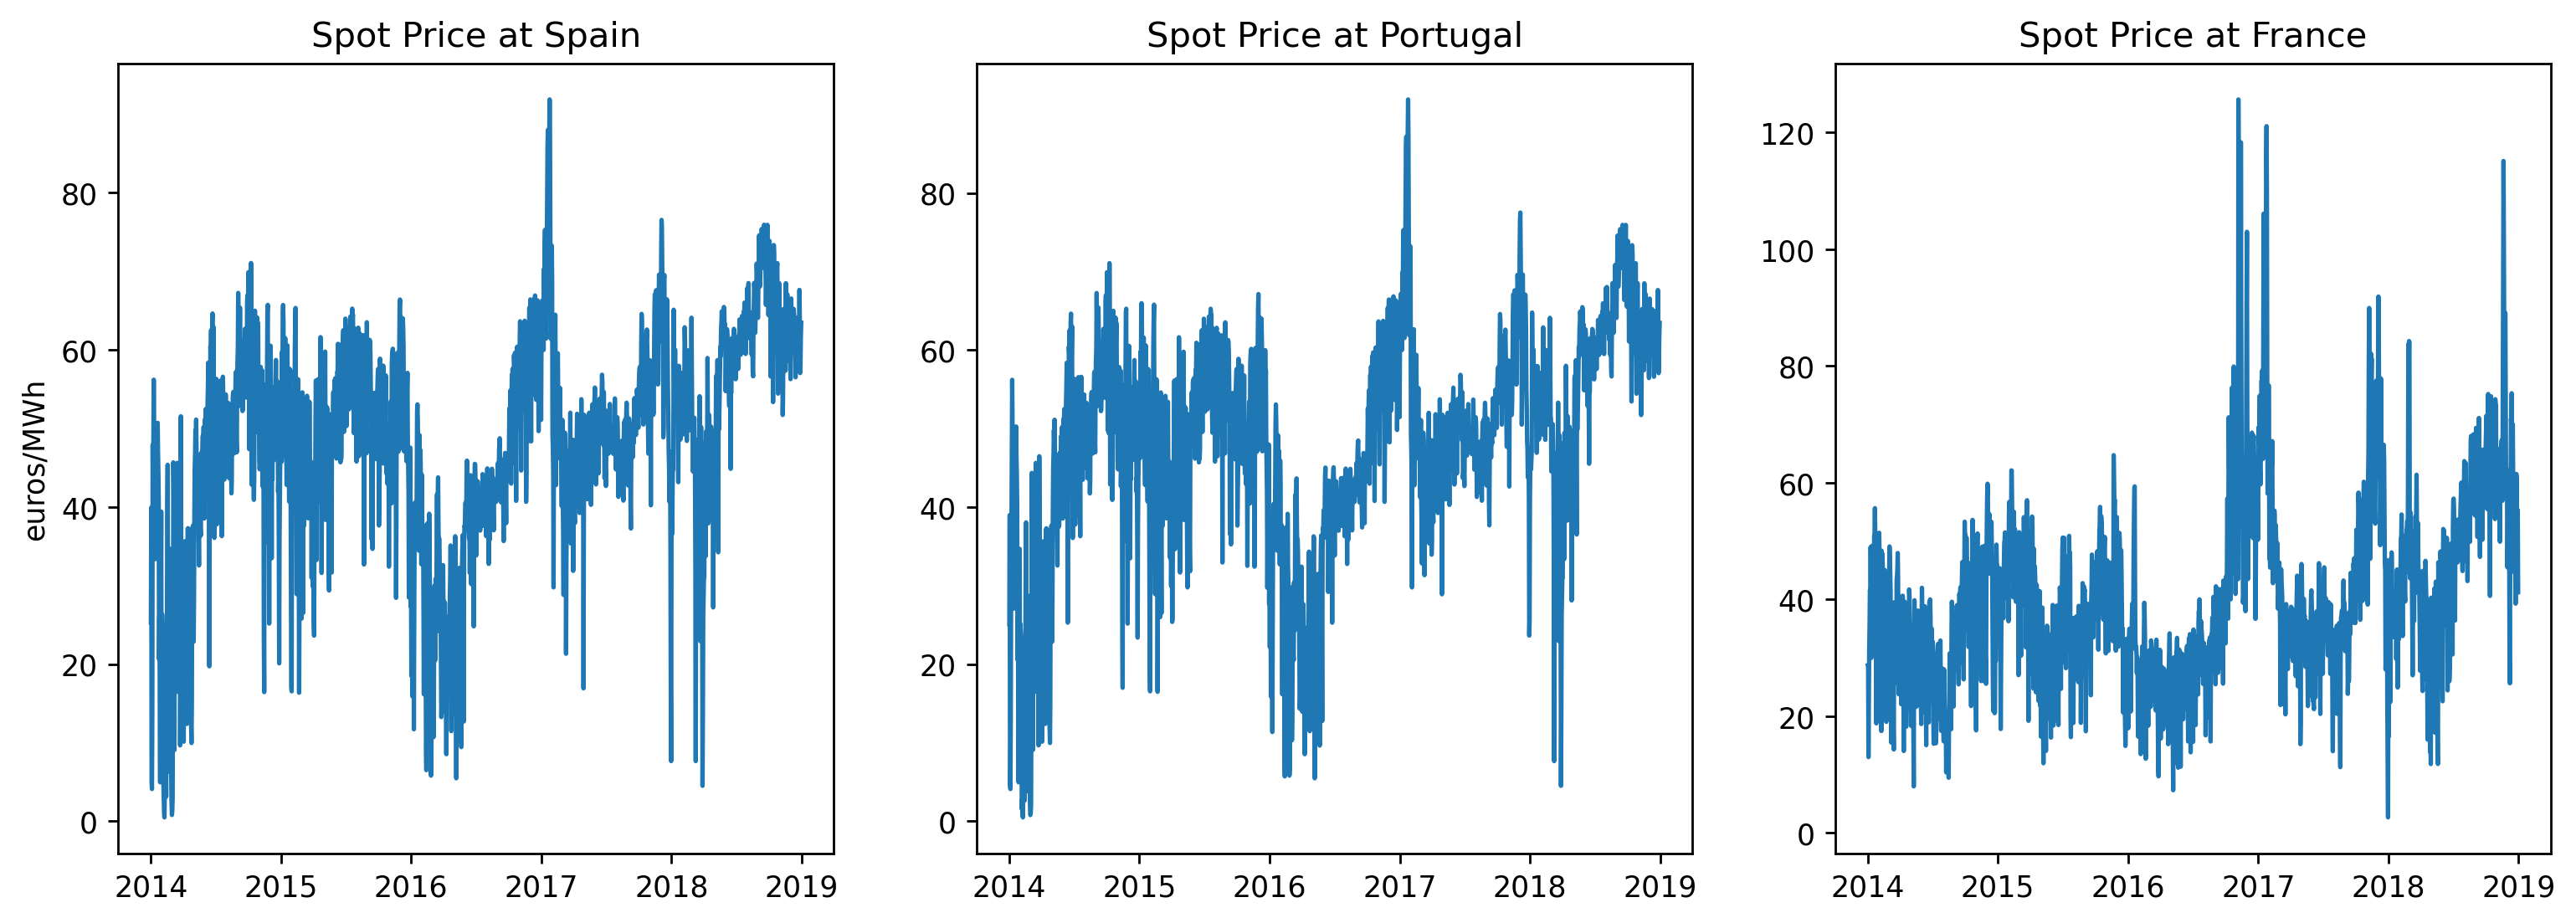

In [3]:
# Let see the daily spot market price at Spain, Portugal and France
dfSpotPor = dfData[dfData['name'] == 'Precio mercado SPOT Diario POR'].loc[:,['datetime','value']]
dfSpotFra = dfData[dfData['name'] == 'Precio mercado SPOT Diario FRA'].loc[:,['datetime','value']]
dfSpotEsp = dfData[dfData['name'] == 'Precio mercado SPOT Diario ESP'].loc[:,['datetime','value']]
dfSpot    = dfSpotEsp.merge(dfSpotPor, on='datetime').merge(dfSpotFra, on='datetime').set_index('datetime')
dfSpot.columns = ['Spot_Esp', 'Spot_Por', 'Spot_Fra']
dfSpot.index   = pd.to_datetime(dfSpot.index).normalize() # remove hour time

# Plot the spot market time-series
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(dfSpot.loc[:,'Spot_Esp'])
ax[0].set_title('Spot Price at Spain')
ax[0].set_ylabel('euros/MWh')
ax[1].plot(dfSpot.loc[:,'Spot_Por'])
ax[1].set_title('Spot Price at Portugal')
ax[2].plot(dfSpot.loc[:,'Spot_Fra'])
ax[2].set_title('Spot Price at France')

# Print the correlation matrix
print(dfSpot.corr())

So, we see that the spot price at Spain and Portugal are highly correlated (0.99 Pearson correlation!). Regarding France, the spot market there is correlated with the spot market at Spain and Portugal (0.6) although not as much as between Spain and Portugal. 

What we see, it makes sense. However, we should further investigate why Portugal and Spanish markets are so much correlated. Is it because the network/infrastructure dependence between them? 

In [4]:
print(set(dfData.loc[:,'name']))

{nan, 'Precio mercado SPOT Diario FRA', 'Demanda real', 'Precio mercado SPOT Diario ESP', 'Generación programada PBF Solar fotovoltaica', 'Demanda programada PBF total', 'Generación programada PBF Carbón', 'Rentas de congestión mecanismos implícitos diario Francia exportación', 'Generación programada PBF Eólica', 'Generación programada PBF Gas Natural Cogeneración', 'Energía asignada en Mercado SPOT Diario Francia', 'Generación programada PBF Turbinación bombeo', 'Rentas de congestión mecanismos implícitos diario Portugal importación', 'Generación programada PBF total', 'Generación programada PBF Ciclo combinado', 'Rentas de congestión mecanismos implícitos diario Portugal exportación', 'Generación programada PBF Nuclear', 'Precio mercado SPOT Diario POR', 'Rentas de congestión mecanismos implícitos diario Francia importación', 'Generación programada PBF UGH + no UGH', 'Energía asignada en Mercado SPOT Diario España'}


          Por_Imp   Por_Exp
Por_Imp  1.000000  0.016434
Por_Exp  0.016434  1.000000
                  datetime    value
18505  2014-01-01 23:00:00  10811.0
18506  2014-01-02 23:00:00  43035.0
18507  2014-01-03 23:00:00  14060.0
18508  2014-01-04 23:00:00      0.0
18509  2014-01-05 23:00:00  37620.0


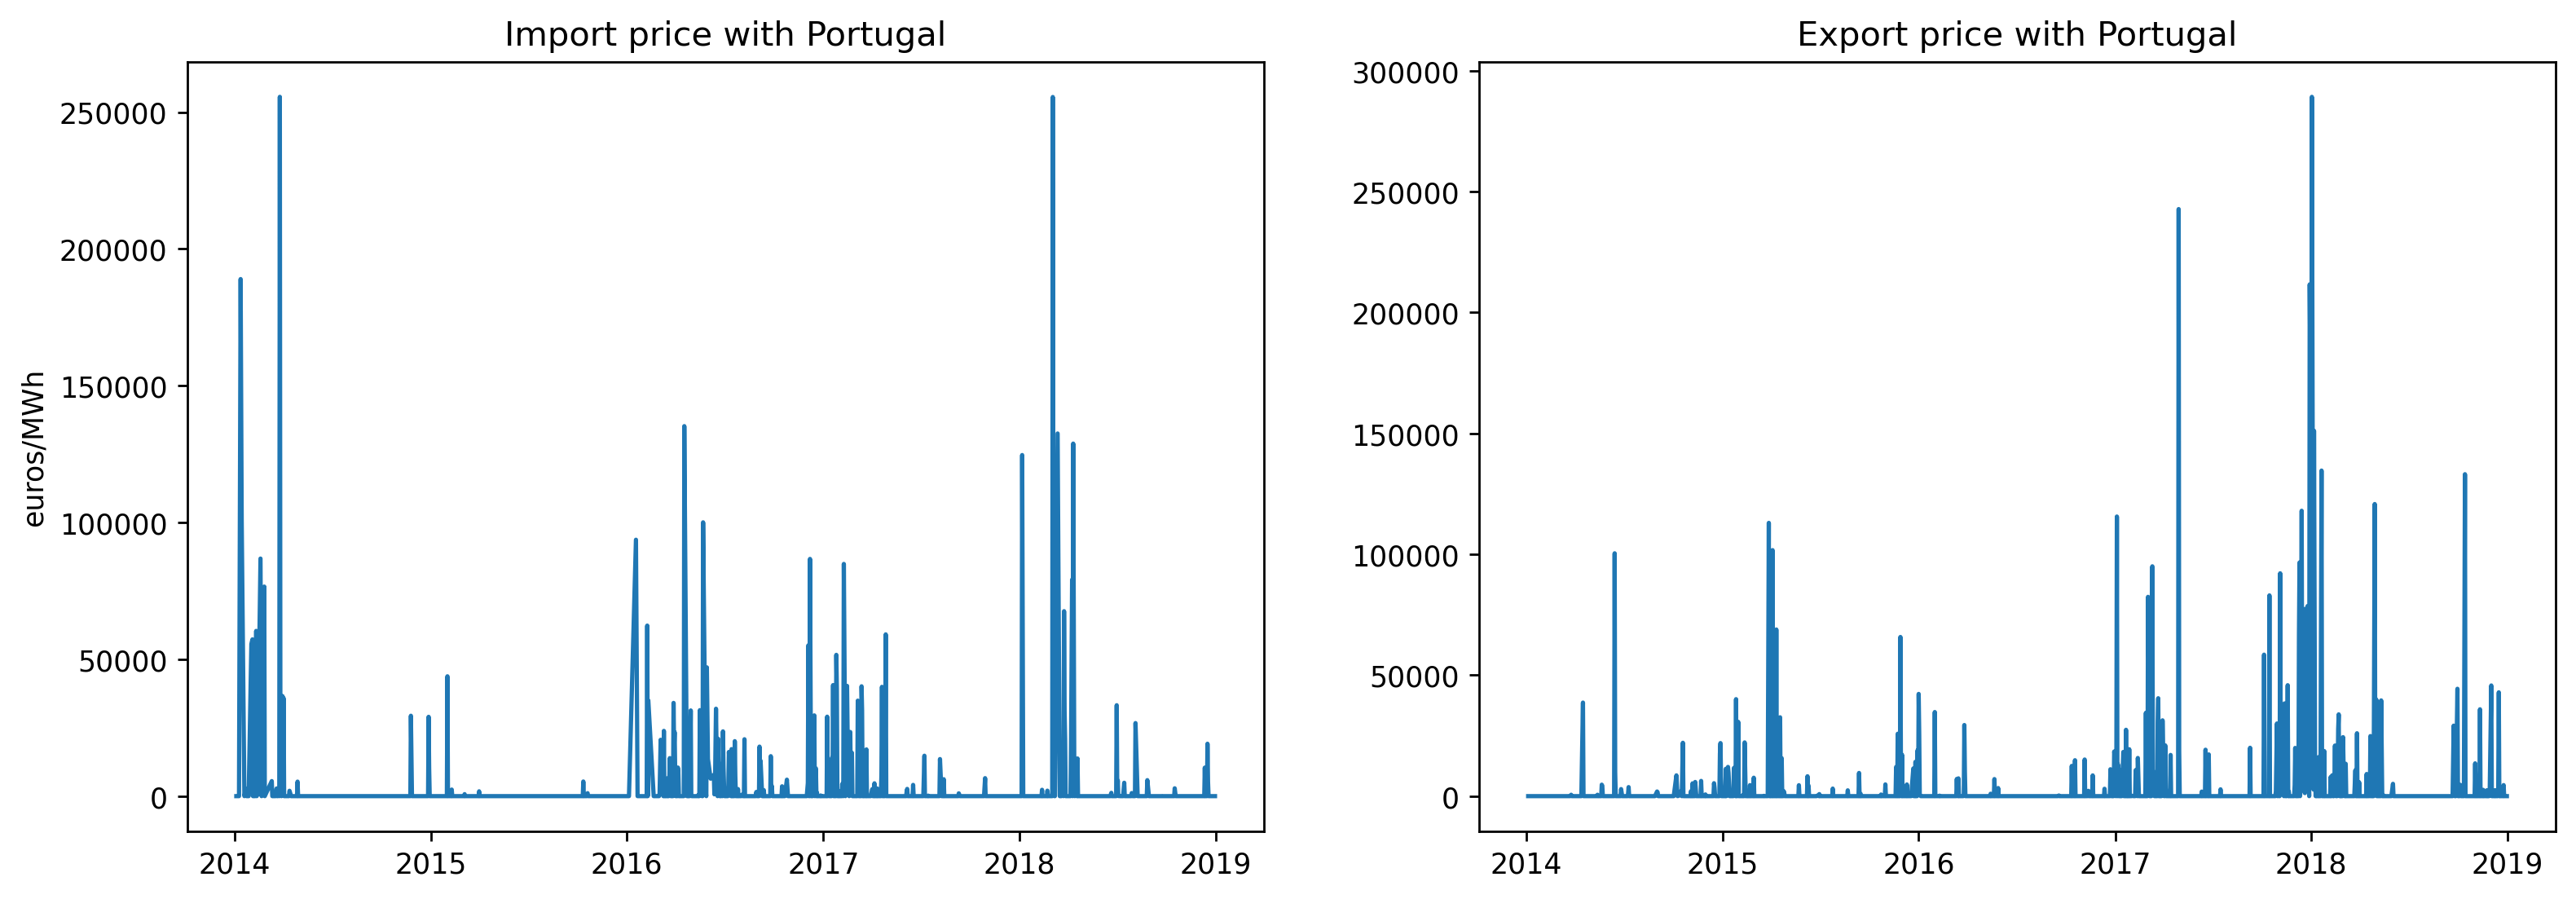

In [5]:
# Let see the daily spot market price at Spain, Portugal and France
dfImpPor = dfData[dfData['name'] == 'Rentas de congestión mecanismos implícitos diario Portugal importación'].loc[:,['datetime','value']]
dfExpPor = dfData[dfData['name'] == 'Rentas de congestión mecanismos implícitos diario Portugal exportación'].loc[:,['datetime','value']]
dfPor    = dfImpPor.merge(dfExpPor, on='datetime').set_index('datetime')
dfPor.columns = ['Por_Imp', 'Por_Exp']
dfPor.index   = pd.to_datetime(dfPor.index).normalize() # remove hour time

# Plot the Portugal's import/export market time-series
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(dfPor.loc[:,'Por_Imp'])
ax[0].set_title('Import price with Portugal')
ax[0].set_ylabel('euros/MWh')
ax[1].plot(dfPor.loc[:,'Por_Exp'])
ax[1].set_title('Export price with Portugal')

# Print the correlation matrix
print(dfPor.corr())

#### 4) How does different energy sources demand has evolved over time?

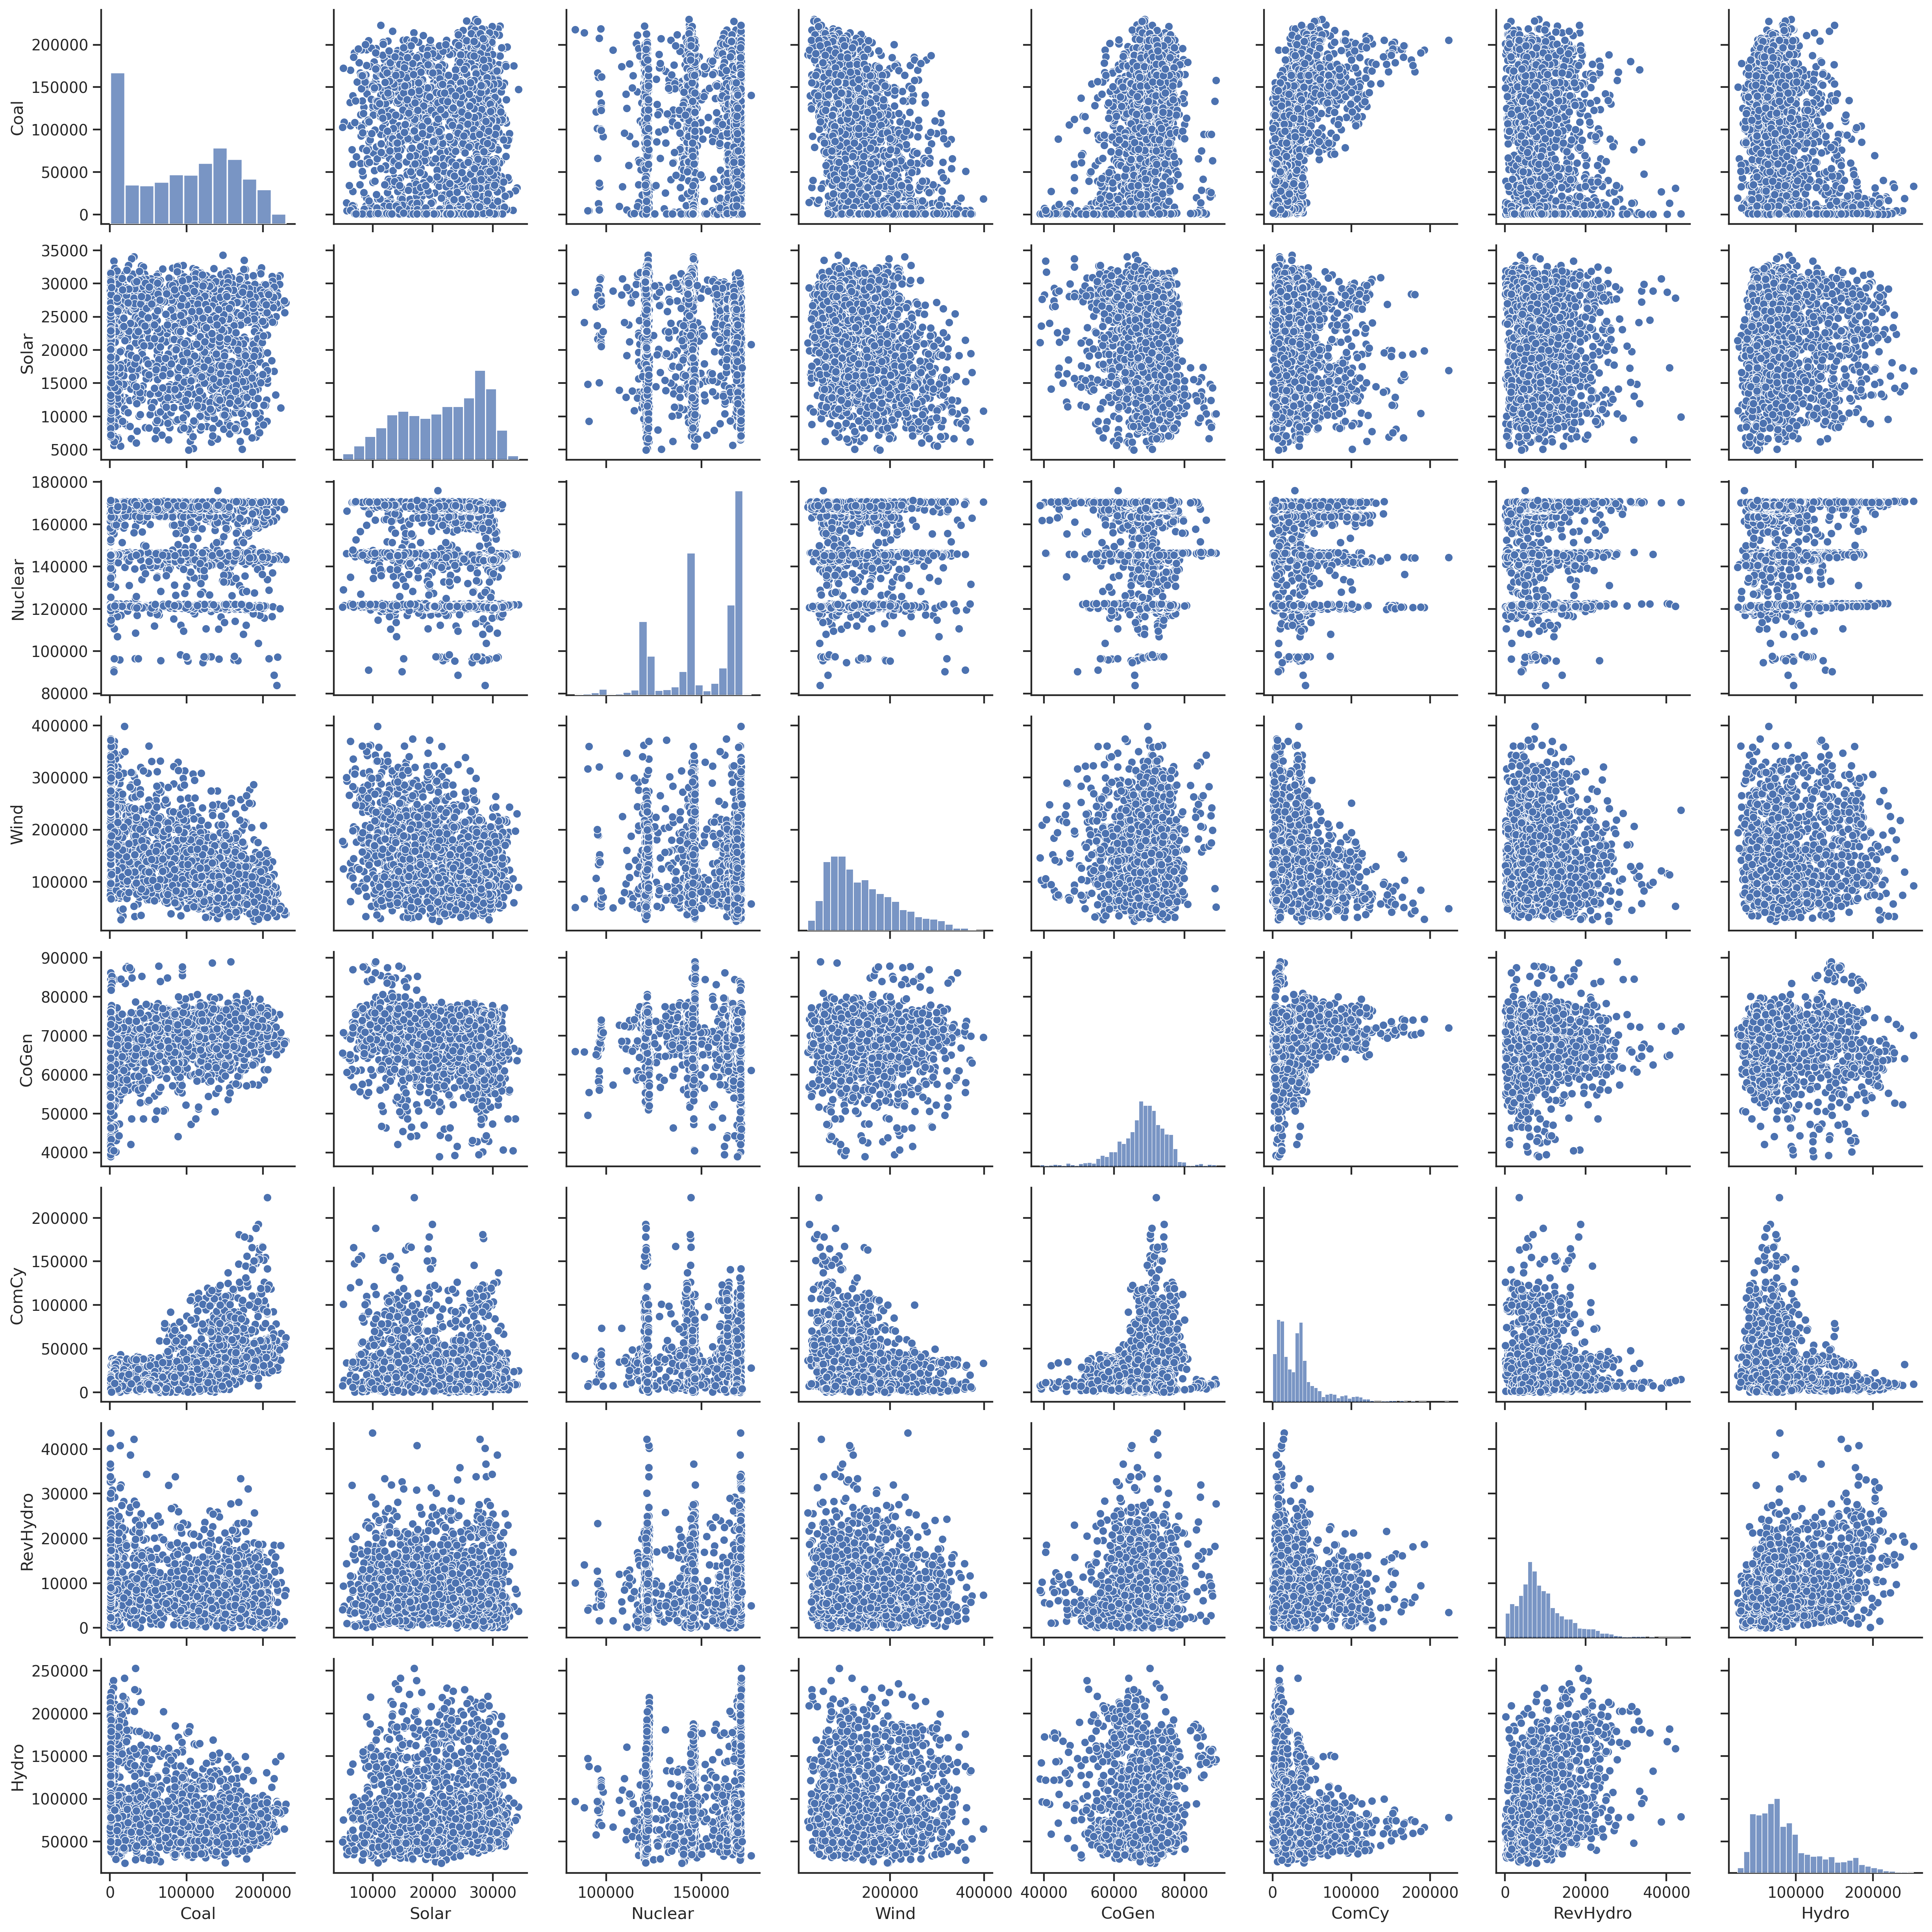

In [6]:
# Retrieve energy generation from different sources
dfCoal      = dfData[dfData['name'] == 'Generación programada PBF Carbón'].loc[:,['datetime','value']]
dfSolar     = dfData[dfData['name'] == 'Generación programada PBF Solar fotovoltaica'].loc[:,['datetime','value']]
dfNuclear   = dfData[dfData['name'] == 'Generación programada PBF Nuclear'].loc[:,['datetime','value']]
dfWind      = dfData[dfData['name'] == 'Generación programada PBF Eólica'].loc[:,['datetime','value']]
dfCoGen     = dfData[dfData['name'] == 'Generación programada PBF Gas Natural Cogeneración'].loc[:,['datetime','value']]
dfComCy     = dfData[dfData['name'] == 'Generación programada PBF Ciclo combinado'].loc[:,['datetime','value']]
dfRevHydro  = dfData[dfData['name'] == 'Generación programada PBF Turbinación bombeo'].loc[:,['datetime','value']]
dfHydro     = dfData[dfData['name'] == 'Generación programada PBF UGH + no UGH'].loc[:,['datetime','value']]

# Dataframes are merged
list_dfs  = [dfCoal, dfSolar, dfNuclear, dfWind, dfCoGen, dfComCy, dfRevHydro, dfHydro]
dfSources = pd.concat([df.set_index('datetime') for df in list_dfs], axis=1)
dfSources.columns = ['Coal', 'Solar', 'Nuclear', 'Wind', 'CoGen', 'ComCy', 'RevHydro', 'Hydro']
dfSources.index   = pd.to_datetime(dfSources.index).normalize() # remove hour time

# Plot a multiple scatter plot matrix
sns.set_theme(style="ticks")
sns.pairplot(dfSources)


What are the leading energy sources in Spain? This information can be retrieved using PCA analysis. Let's get the leading components.

In [47]:
# Preprocess data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(dfSources)

# Perform PCA
pca = PCA()
principal_components = pca.fit_transform(scaled_data)

# Plot the principal components
plt.figure(figsize=(8, 6))
plt.scatter(principal_components[:, 0], principal_components[:, 1], c='b', marker='o')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Principal Components')
plt.grid(True)
plt.show()

NameError: name 'StandardScaler' is not defined

#### 5) Seasonalities in the electricity market

Let's first check the seasonalities that we can find within the year. For that, I will group the real demand by months.

Text(0.5, 1.0, 'Spanish electricity market from 2014-01-01 to 2018-12-30')

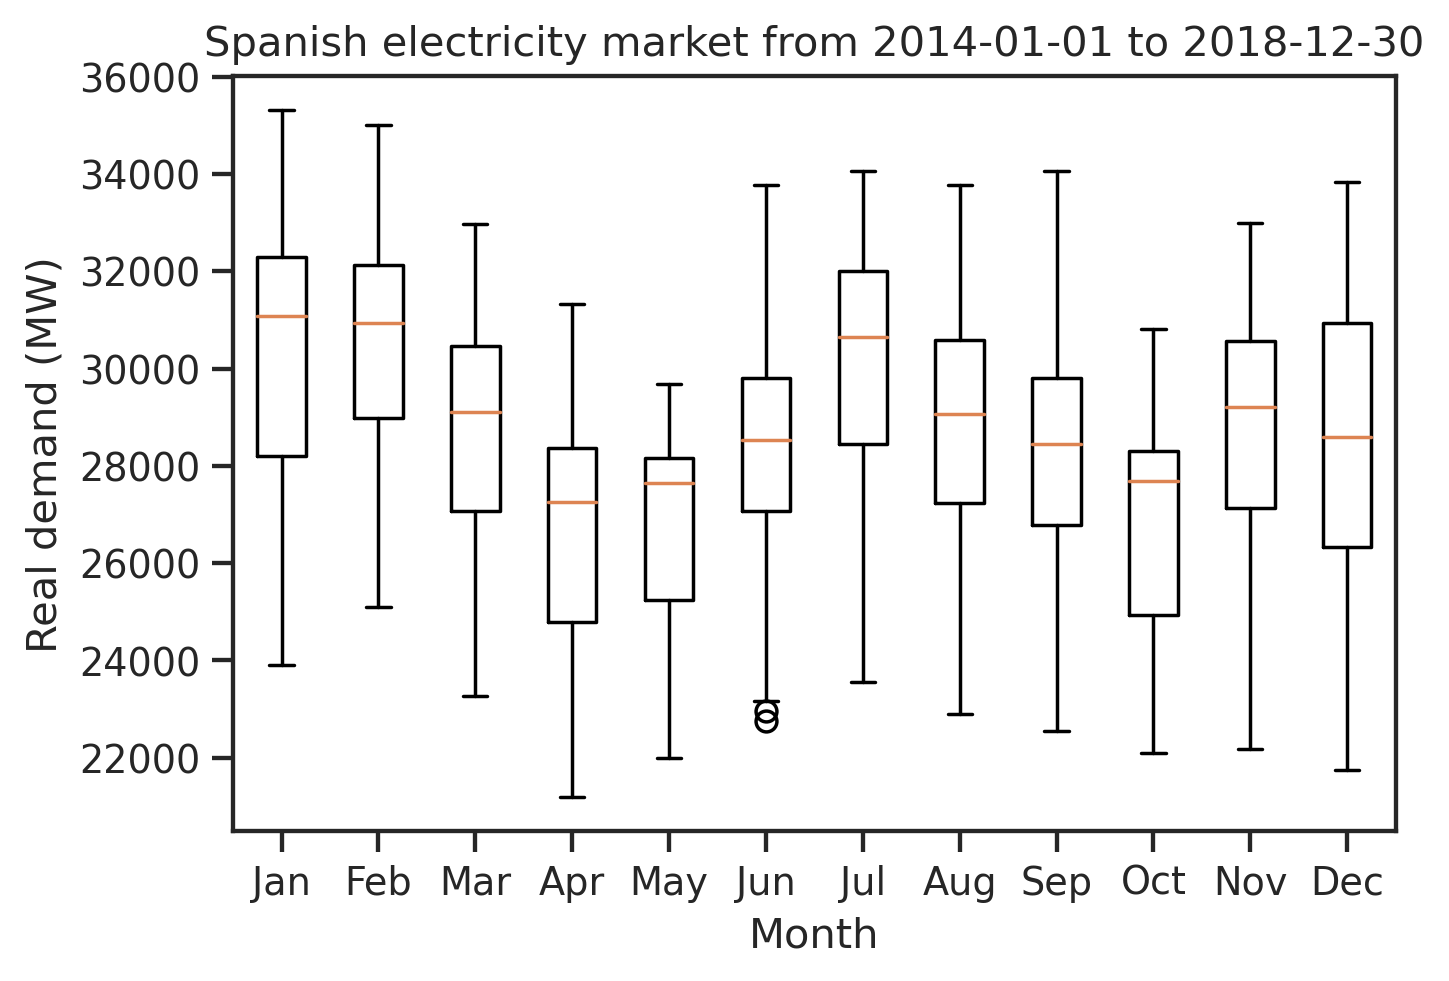

In [7]:
# First, we get the real demand
dfDemand = dfData[dfData['name'] == 'Demanda real'].loc[:,['datetime','value']].set_index('datetime')
dfDemand.index   = pd.to_datetime(dfDemand.index).normalize()

# Then, group data by month
dfDemand['month'] = dfDemand.index.month
dfGrouped = dfDemand.groupby('month')

# Iterate through each month group
boxplot_data = []
for month, data in dfGrouped:
    boxplot_data.append(data['value'])

# Show data in a boxplot
fig, ax = plt.subplots()
ax.boxplot(boxplot_data)
months = [
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
]
ax.set_xticklabels(months)
ax.set_xlabel('Month')
ax.set_ylabel('Real demand (MW)')
ax.set_title('Spanish electricity market from ' + dfDemand.index[0].strftime('%Y-%m-%d') + ' to ' + dfDemand.index[-1].strftime('%Y-%m-%d'))

We see some seasonality effects in the data. For example, the median increases at winter months (Nov, Dec, Jan and Feb) due to the low temperatures. It also increases during summer due to the high temperatures. Nevertheless, in mild temperature months (Autumn and Spring) the electricity demand decreases.

Uncertainty intervals are quite width, therefore the interpratation given in the paragraph above is not totally correct. These width intervals could be caused by some years with higher or lower temperatures from usual. Therefore, let us check the boxplot for each year.

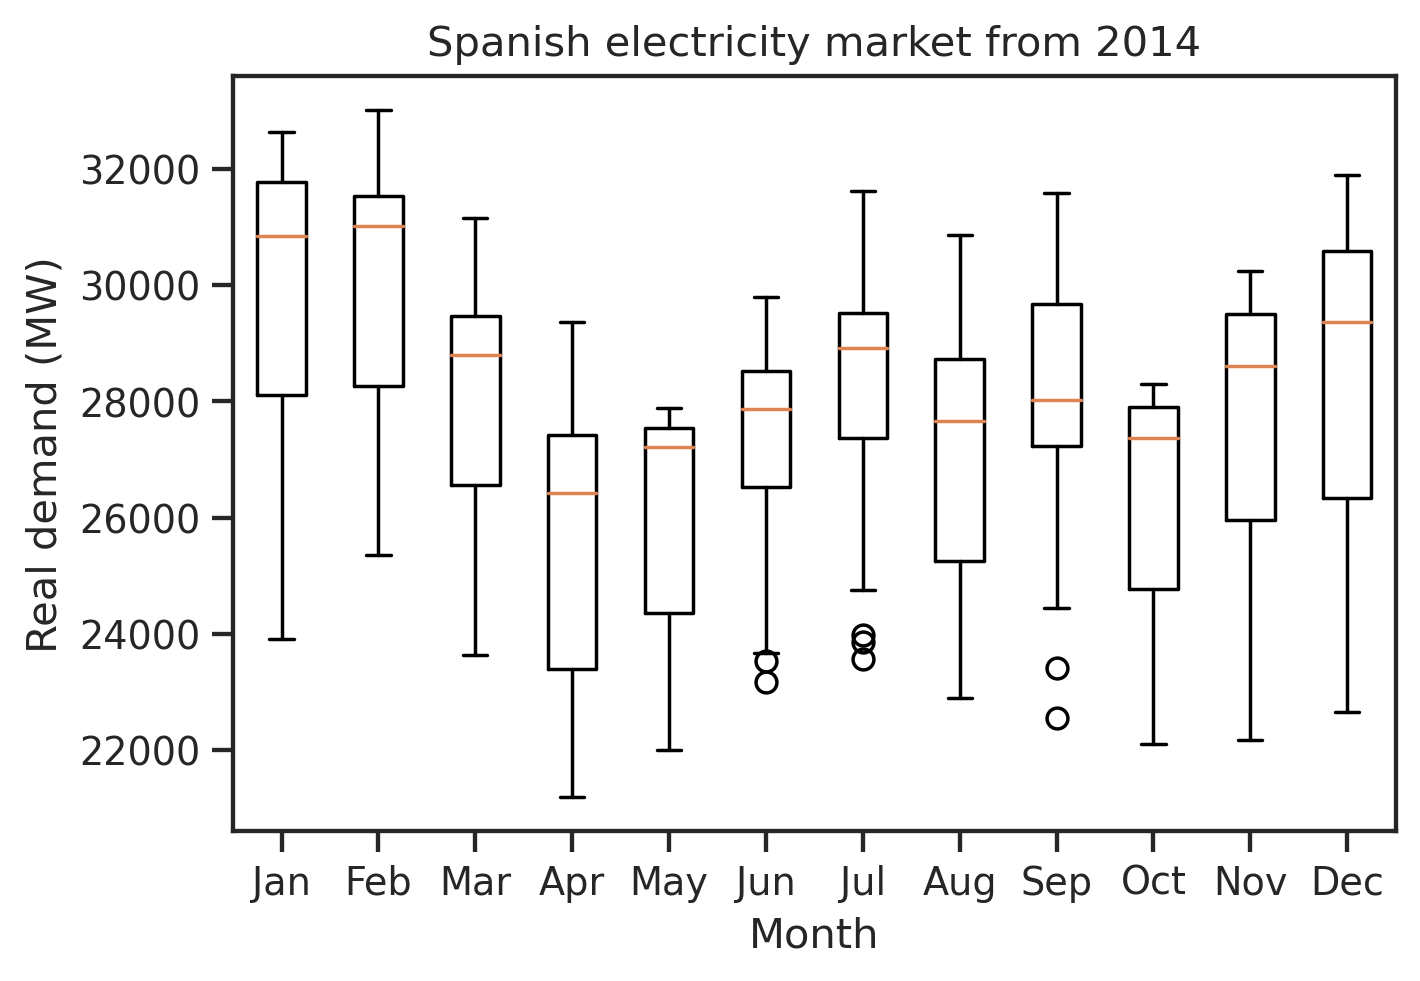

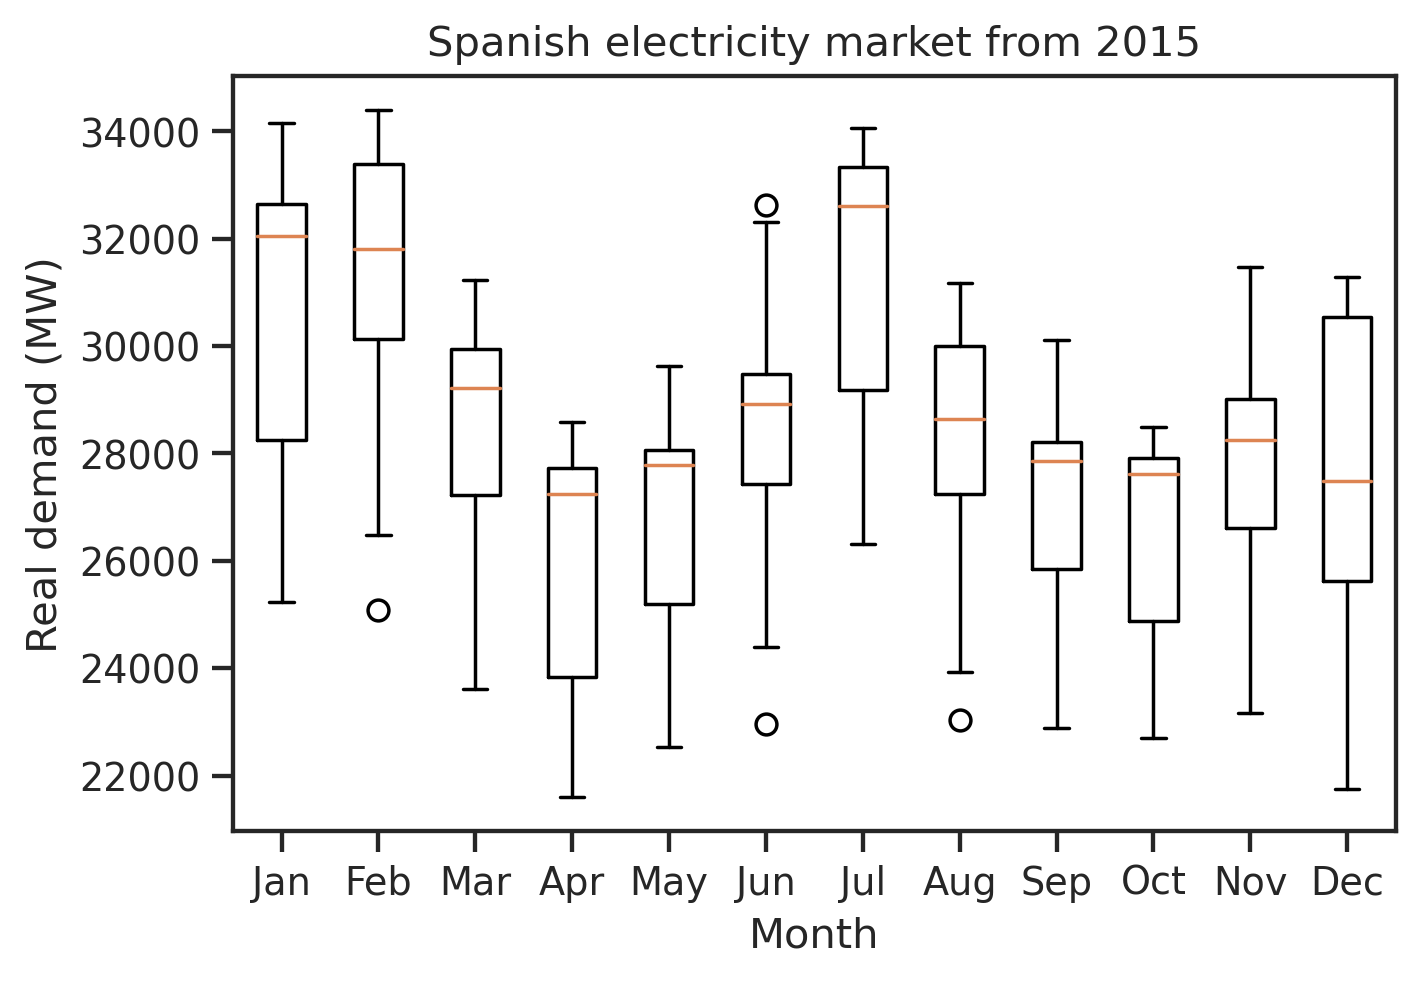

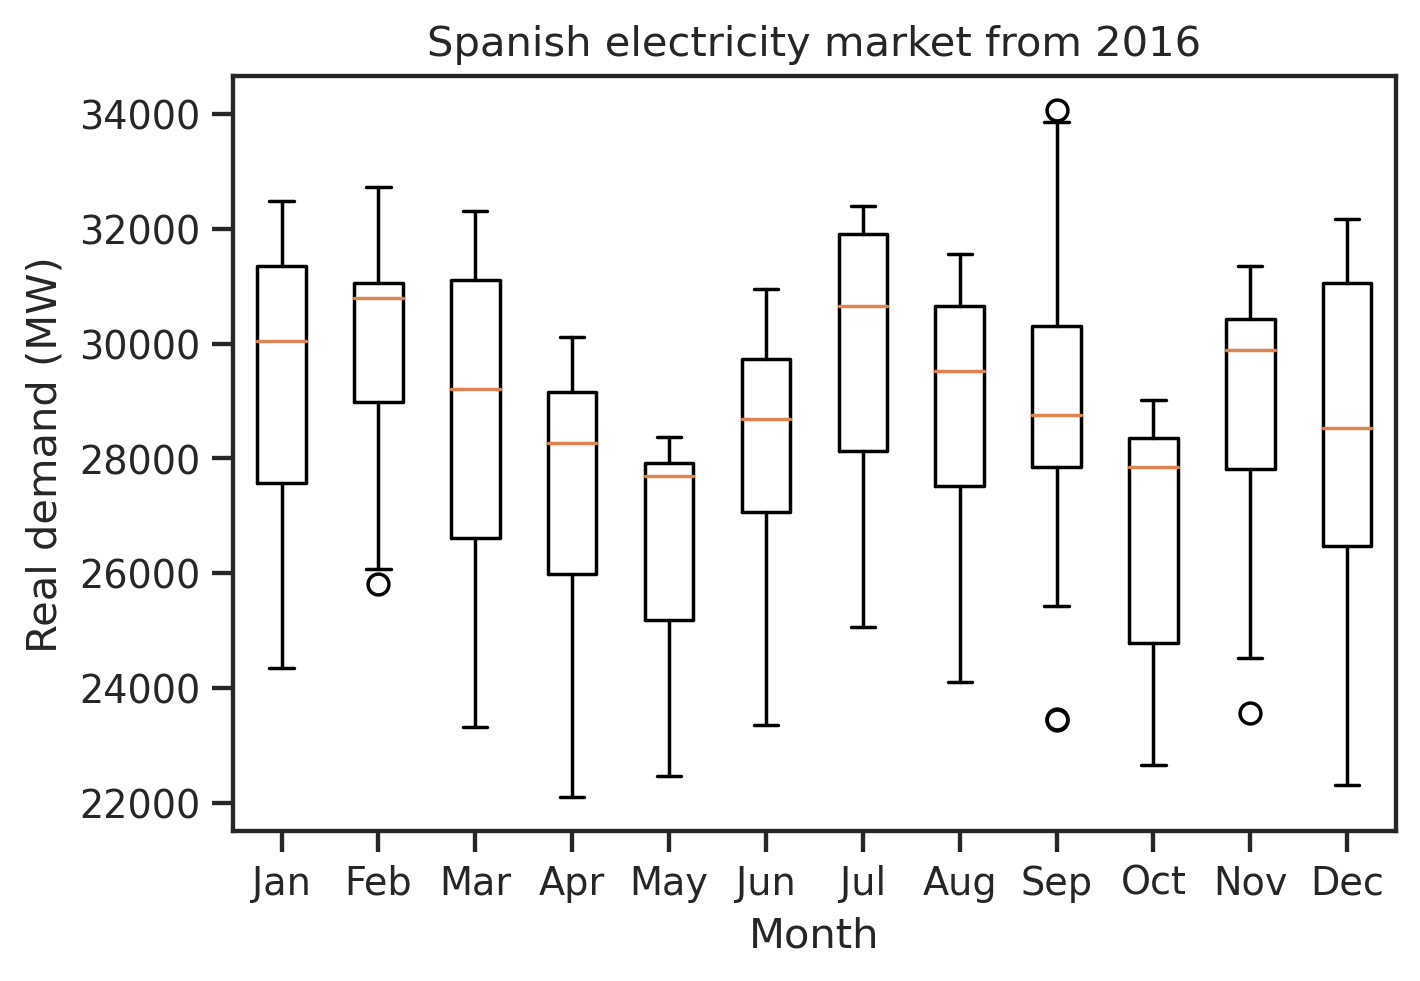

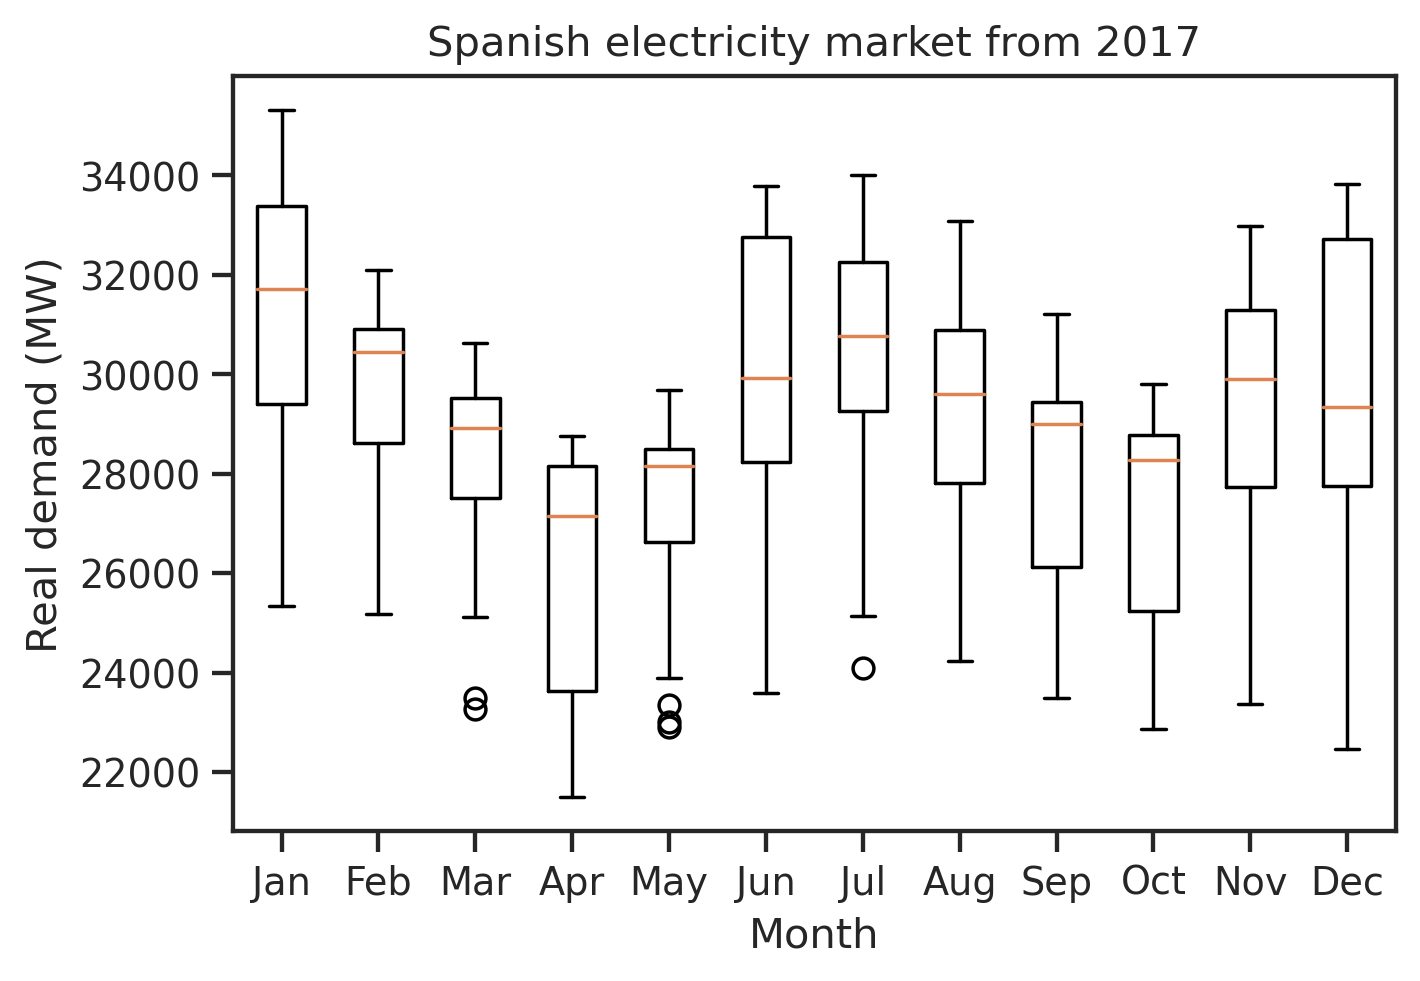

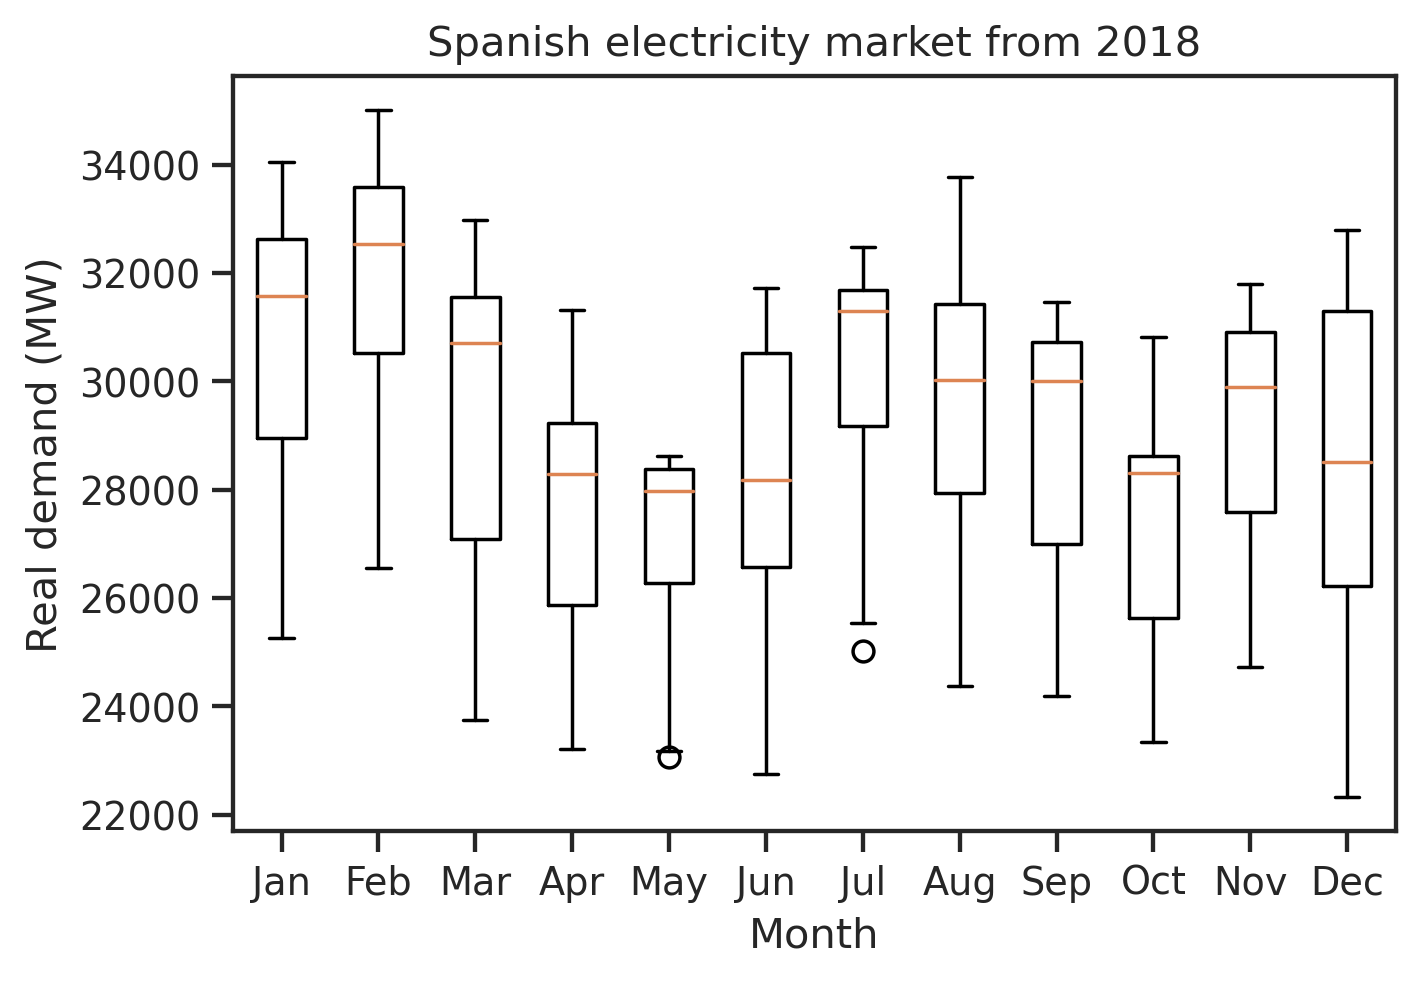

In [8]:
years_data = sorted(set(dfDemand.index.year))

for yeari in years_data:
    dfDemand_i = dfDemand.loc[str(yeari) + '-01-01': str(yeari) + '-12-31']

    # Group data by month
    dfDemand_i.loc[:,'month'] = dfDemand_i.index.month
    dfGrouped = dfDemand_i.groupby('month')

    # Iterate through each month group
    boxplot_data = []
    for month, data in dfGrouped:
        boxplot_data.append(data['value'])

    # Show data in a boxplot
    fig, ax = plt.subplots()
    ax.boxplot(boxplot_data)
    months = [
        'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
        'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
    ]
    ax.set_xticklabels(months)
    ax.set_xlabel('Month')
    ax.set_ylabel('Real demand (MW)')
    ax.set_title('Spanish electricity market from ' + str(yeari))

#### 6) Demand dependence on temperature

Now, we will explore the temperature dependence of electricity demand. The temperature data was sourced from NOAA, a US institute. The average temperature was determined by calculating the mean across more than 70 meteorological stations in Spain. While this method lacks complete accuracy (temperatures ideally should be weighted based on the areas they represent), it serves as a suitable initial approximation.

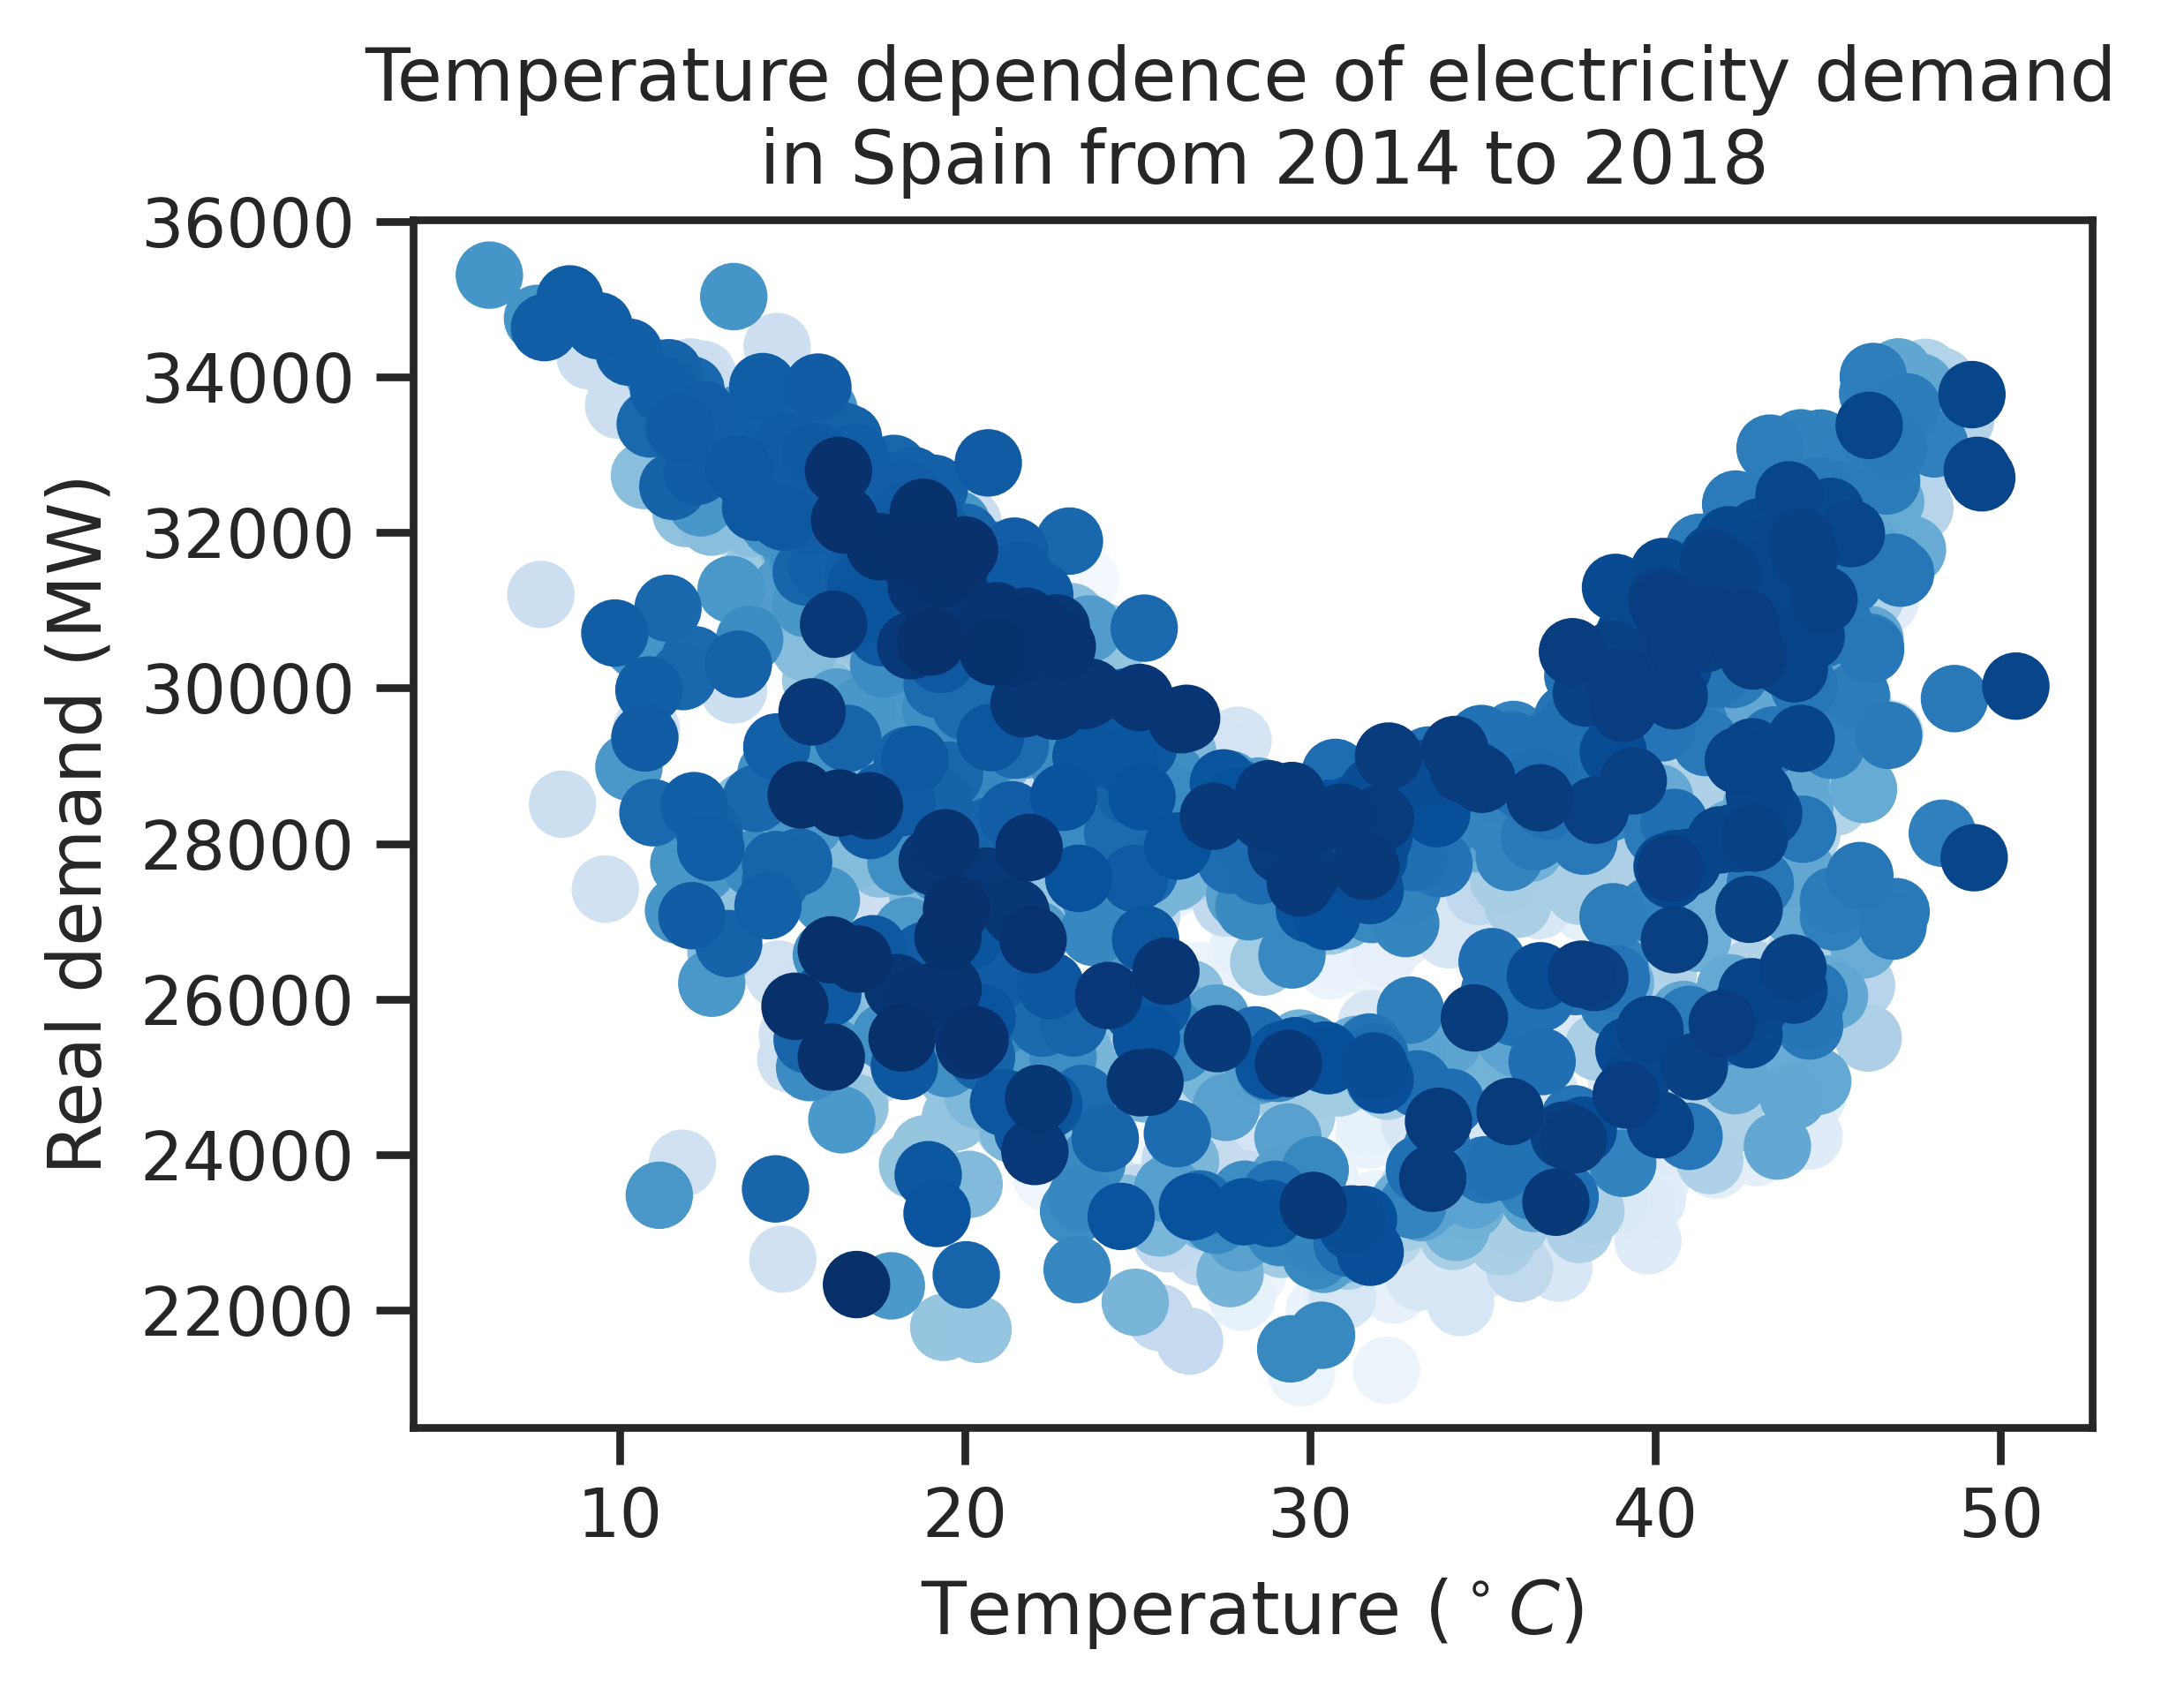

In [40]:
# Filter data
dfDemand    = dfData[dfData['name'] == 'Demanda real'].loc[:,['datetime','value']].set_index('datetime')
dfTempSpain = dfTemp.loc[:, ['DATE', 'TAVG']]
dfDemand.index = pd.to_datetime(dfDemand.index).normalize()

# Group by date
dfTempSpain['DATE'] = pd.to_datetime(dfTempSpain['DATE'])
dfTempAvg = dfTempSpain.groupby(dfTempSpain['DATE'].dt.date)['TAVG'].mean()

# Convert from Farenheit to Celsius
dfTempAvg = dfTempAvg - 32

# Merge temperature and demand
dfMerged = dfDemand.merge(dfTempAvg, left_index=True, right_index=True)

# Scatter plot
my_dpi = 500
plt.figure(figsize=(2500/my_dpi, 2000/my_dpi), dpi=my_dpi)
cmap = plt.get_cmap('Blues')
idxs = np.linspace(0,1,dfMerged.shape[0])
plt.scatter(dfMerged['TAVG'], dfMerged['value'], c=cmap(idxs), s=100)
plt.ylabel('Real demand (MW)')
plt.xlabel('Temperature ($^\circ C$)')
plt.title('Temperature dependence of electricity demand \n in Spain from ' + str(dfMerged.index[0].year) + ' to ' + str(dfMerged.index[-1].year))
plt.tight_layout()
#plt.savefig('para_web.png', format='png', dpi=my_dpi)

We see a clear dependance on the temperature. Temperatures around 30 degrees imply the minimum demand of electricity. Whereas low and high temperatures (below 20 and over 40 degrees) imply an increment in the electricity demand in Spain.